In [568]:
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from itertools import groupby
from operator import itemgetter

In [569]:
import numpy as np
from scipy import stats
from datascience import *
from scipy.signal import savgol_filter

read_data = Table.read_table("icos-cd4.csv")
chrom = "chr1"
start = read_data.column(0).item(0)
stop = read_data.column(0).item(read_data.num_rows - 1)
columns = read_data.num_columns

In [570]:
def MA_normalization(read_data):
    M = np.log(read_data.column(1) + .999999) - np.log(read_data.column(2) + .999999)
    A = (np.log(read_data.column(1) + .999999) + np.log(read_data.column(2) + .999999))
    Table().with_columns("Raw M", M, "A", A).scatter("A", fit_line=True)
    slope, intercept, r_value, p_value, std_err =  stats.linregress(A,M)
    adjusted_M = M - ((slope*A)+intercept)
    Table().with_columns("Adjusted M", adjusted_M, "A", A).scatter("A", fit_line=True)
    print("Slope: " + str(slope) + "  Intercept: " + str(intercept))
    return Table().with_columns("Adjusted M", adjusted_M, "A", A)
def MA_normalization_no_summary(read_data):
    M = np.log(read_data.column(1) + .999999) - np.log(read_data.column(2) + .999999)
    A = (np.log(read_data.column(1) + .999999) + np.log(read_data.column(2) + .999999))
    slope, intercept, r_value, p_value, std_err =  stats.linregress(A,M)
    adjusted_M = M - ((slope*A)+intercept)
    return Table().with_columns("Adjusted M", adjusted_M, "A", A)

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
def linear_weight_moving_average(signal, period):
    buffer = [0.0] * period
    for i in range(period, len(signal)):
        buffer.append(
            (signal[i - period : i] * (np.arange(period) + 1)).sum()
            / (np.arange(period) + 1).sum()
        )
    return buffer

#x = data_comp.select(0).with_column("1", savgol_filter(data_comp.column(1), 11, 3)).take(np.arange(8000,9000))
#x.plot(0,1)
#data_comp.select(0).with_column("1", savgol_filter(data_comp.column(1), 111, 3)).take(np.arange(8000,9000)).plot(0,1)

In [571]:
stop

61000320

# 1. M-A Normalization

def optimal_filter(win, order):
    filtered = savgol_filter(MA_normalization_no_summary(read_data).column("Adjusted M"), win,order)
    raw = MA_normalization_no_summary(read_data).column("Adjusted M")
    mse = np.mean((filtered - raw)**2)
    return mse


def minimize():
    order_arr = make_array()
    window_arr = make_array()
    mse_arr = make_array()
    windows = np.arange(1,50,2)
    for window in windows:
        for order in np.arange(1, window):
            mse = optimal_filter(window, order)
            order_arr = np.append(order_arr, order)
            window_arr = np.append(window_arr, window)
            mse_arr = np.append(mse_arr, mse)
    summary = Table().with_columns("Order",order_arr, "Window", window_arr,"MSE", mse_arr )
    return summary.where("MSE", are.equal_to(min(summary.column(2))))
summary = minimize()     

Slope: -0.028299369805721026  Intercept: -0.14860064991895422


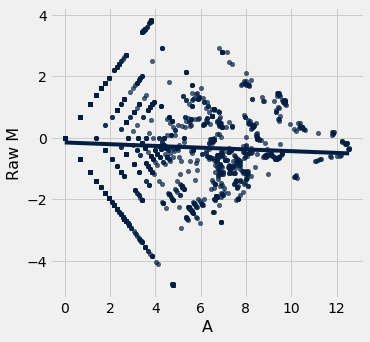

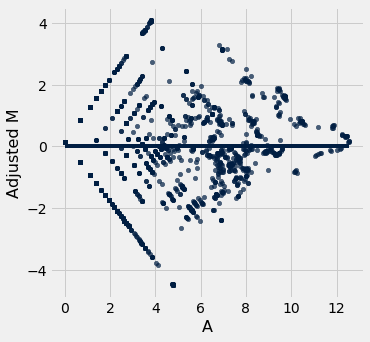

In [572]:
data_comp = read_data.with_column("Adjusted_Fitted_M", savgol_filter(MA_normalization(read_data).column("Adjusted M"), 21,1))
#data_comp = read_data.with_column("Adjusted_Fitted_M", savgol_filter(MA_normalization(read_data).column("Adjusted M"), int(summary.column(1).item(0)),int(summary.column(0).item(0))))


#ready_mv = data_comp.select(0).with_column("1", np.abs(savgol_filter(data_comp.column(1),21,1)),"2", np.abs(savgol_filter(data_comp.column(2),21,1)) )
#data_comp_mv = ready_mv.with_column("adjusted_M", MA_normalization(ready_mv).column("Adjusted M"))
data_comp_mv = data_comp

In [573]:
#scipy.stats.normaltest(
normal_table = Table().with_column("Adjusted_Fitted_M", ((data_comp.column(3)-np.mean(data_comp.column(3)))/np.std(data_comp.column(3))))
normal_table = normal_table.select("Adjusted_Fitted_M").bin(0, bins=np.arange(min(normal_table.column(0)),max(normal_table.column(0)),(max(normal_table.column(0)) - min(normal_table.column(0)))/8))
#normal_table.plot(0,1)
from scipy import stats 
#print("Chi Squared: "+ str(stats.normaltest(normal_table.column(0))))

Standard Deviation: 1.2048116736810315


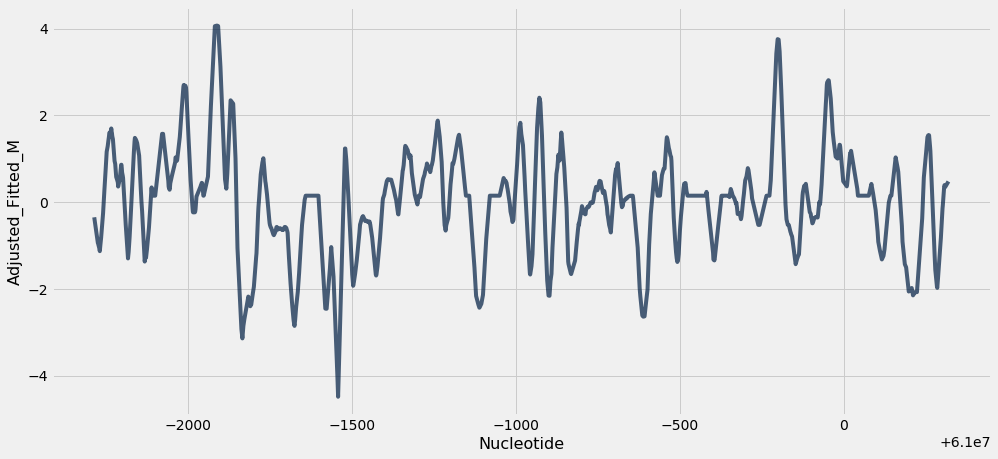

In [574]:
data_comp.relabeled(0, "Nucleotide").plot(0,3,width=15, height=7)
print("Standard Deviation: " + str(np.std(data_comp.column("Adjusted_Fitted_M"))))

## 2. Savitzky–Golay filter

## 3. Summary

In [575]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    summ = list(zip(edges, edges))
    start = [summ[x][0] for x in np.arange(len(summ))]
    stop = [summ[x][1] for x in np.arange(len(summ))]
    
    return Table().with_columns("start", start, "stop", stop, "range", [i-j for i,j in zip(stop,start)])

In [576]:
data_comp_old = data_comp
Adjusted_Fitted_M = data_comp.column(3)
data_comp = data_comp.select(0,1,2).with_column("Adjusted_Fitted_Normalized_M", (data_comp.column(3)- np.mean(data_comp.column(3))/(np.std(data_comp.column(3)))))

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


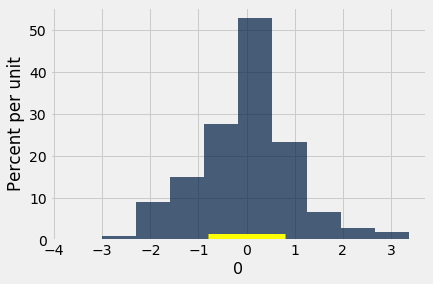

In [577]:
def tbl_generator(upper):
        upper = upper
        lower = -upper
        u = np.mean(data_comp.column(3))
        o = np.std(data_comp.column(3))
        summary_tbl = data_comp.with_column("Greater Binding in Condition 1", ((data_comp.column(3)-u)/o)>upper)
        summary_tbl = summary_tbl.with_column("Greater Binding in Condition 2", ((data_comp.column(3)-u)/o)<lower)

        cond_1 = ranges(summary_tbl.where("Greater Binding in Condition 1", are.equal_to(True)).column("Unnamed: 0"))
        cond_2 = ranges(summary_tbl.where("Greater Binding in Condition 2", are.equal_to(True)).column("Unnamed: 0"))
        return cond_1.where("range", are.above(3)), cond_2.where("range", are.above(3)), summary_tbl
z_score = 0.8
cond1, cond2, summ_tbl = tbl_generator(z_score)
Table().with_columns("0", ((data_comp.column(3)-np.mean(data_comp.column(3)))/np.std(data_comp.column(3)))).hist()
plt.plot(make_array(-z_score, z_score), make_array(.01, .01), color='yellow', lw=5, zorder=1)

In [578]:
data_comp = data_comp_old
limit = make_array(percentile(10,data_comp_old.column(0)), percentile(40, data_comp_old.column(0)))
range_clear = data_comp.column("Unnamed: 0")
data_comp = data_comp.where("Unnamed: 0",are.between(limit.item(0), limit.item(1)))
cond1 = cond1.where("start", are.between(limit.item(0), limit.item(1))).where("stop", are.between(limit.item(0), limit.item(1)))
cond2 = cond2.where("start", are.between(limit.item(0), limit.item(1))).where("stop", are.between(limit.item(0), limit.item(1)))
cond1

start,stop,range
60998064,60998110,46
60998122,60998145,23
60998479,60998483,4
60998660,60998680,20


In [579]:
#dclip = Table.read_table("dCLIP-1.7-run-1-int/dCLIP_output.txt")
#sites = dclip.where("chrom", are.equal_to(chrom)).where("position", are.between(start, stop + 1)).select("chrom", "position", "state")

In [580]:
d_cond_1 = sites.where("state", are.equal_to(2)).where("position",are.between(limit.item(0), limit.item(1)))
d_cond_2 = sites.where("state", are.equal_to(0)).where("position",are.between(limit.item(0), limit.item(1)))

In [581]:
#data_comp.join("Unnamed: 0",sites, "position" ).drop("chrom").relabeled("state", "dCLIP Prediction").show()

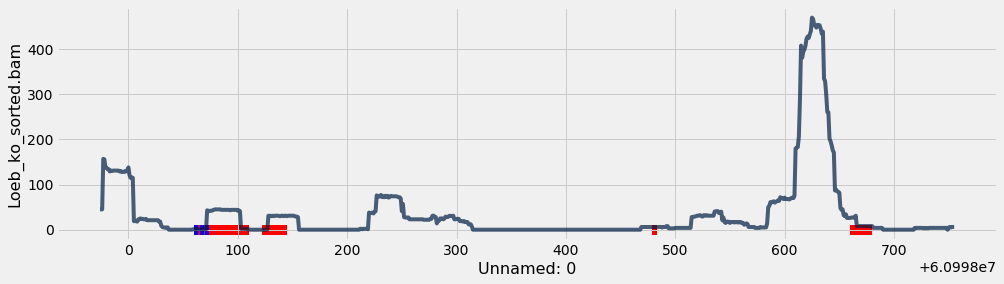

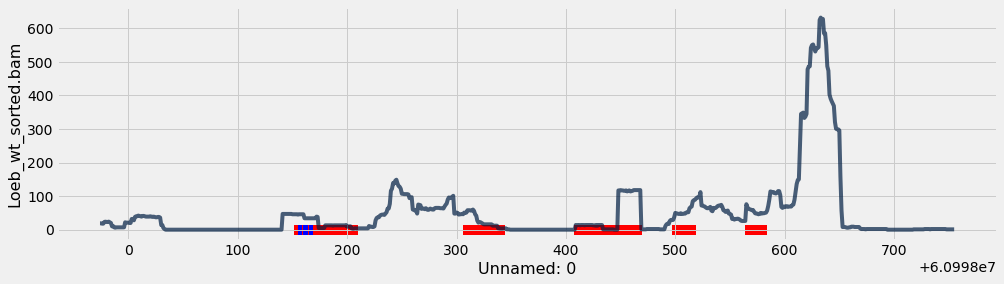

In [582]:
data_comp.plot(0, 1, width=15)
for i in np.arange(len(cond1.column(0))):
    plt.plot(make_array(cond1.column(0).item(i), cond1.column(1).item(i)), make_array(0, 0), color='red', lw=10, zorder=0)

if d_cond_1.num_rows != 0:
    for i in np.arange(len(d_cond_1)):
        plt.plot(make_array(d_cond_1.column(1).item(i), d_cond_1.column(1).item(i)+4), make_array(0, 0), color='blue', lw=10, zorder=0)

    
data_comp.plot(0, 2, width=15)
for i in np.arange(len(cond2.column(0))):
    plt.plot(make_array(cond2.column(0).item(i), cond2.column(1).item(i)), make_array(0, 0), color='red', lw=10, zorder=0)
if d_cond_2.num_rows != 0:
    for i in np.arange(len(d_cond_2)):
        plt.plot(make_array(d_cond_2.column(1).item(i), d_cond_2.column(1).item(i)+4), make_array(0, 0), color='blue', lw=10, zorder=0)

In [561]:
data_comp = data_comp_old

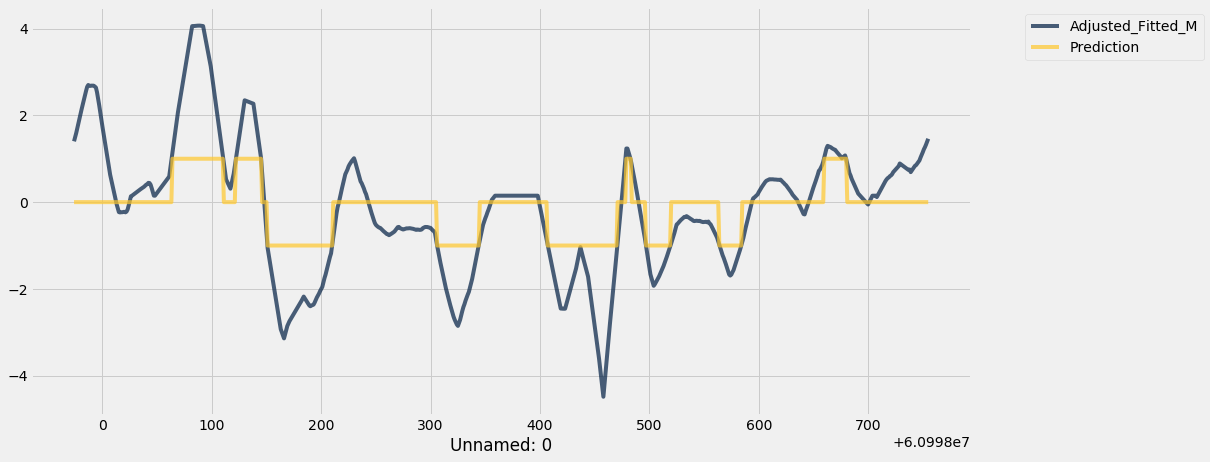

In [562]:
predictions = make_array()
declared = "Undeclared"
for i in np.arange(data_comp.num_rows):
    index_val = data_comp.column(0).item(i)
    for j in np.arange(cond1.num_rows):
        if index_val >= cond1.column(0).item(j) and index_val <= cond1.column(1).item(j):
            declared = 1
            predictions = np.append(predictions, declared)
    for j in np.arange(cond2.num_rows):
        if index_val >= cond2.column(0).item(j) and index_val <= cond2.column(1).item(j):
            declared = -1
            predictions = np.append(predictions, declared)
    if declared == "Undeclared":
        predictions = np.append(predictions, 0)
        
    
    declared = "Undeclared"
data_comp = data_comp.with_column("Prediction", predictions)
data_comp = data_comp.where(0, are.between(limit.item(0),limit.item(1) ))
data_comp.plot(0,make_array(3,4),width=15, height=7)
y_lower = np.mean(data_comp.column("Adjusted_Fitted_M")) - (np.std(data_comp.column("Adjusted_Fitted_M"))*z_score)
y_upper = np.mean(data_comp.column("Adjusted_Fitted_M")) + (np.std(data_comp.column("Adjusted_Fitted_M"))*z_score)
    
#plt.plot(make_array(data_comp.column(0).item(0), data_comp.column(0).item(data_comp.num_rows-1)), make_array(y_upper, y_upper), color='green', lw=3, zorder=0)
#plt.plot(make_array(data_comp.column(0).item(0), data_comp.column(0).item(data_comp.num_rows-1)), make_array(y_lower, y_lower), color='green', lw=3, zorder=0)

#plt.plot(make_array(cond1.column(0).item(i), cond1.column(1).item(i)), make_array(0, 0), color='red', lw=10, zorder=0)

Slope: -0.028299369805721026  Intercept: -0.14860064991895422


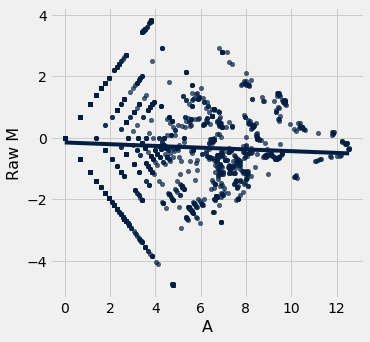

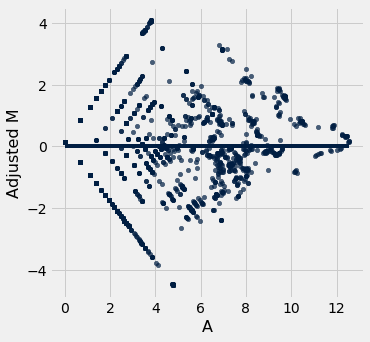

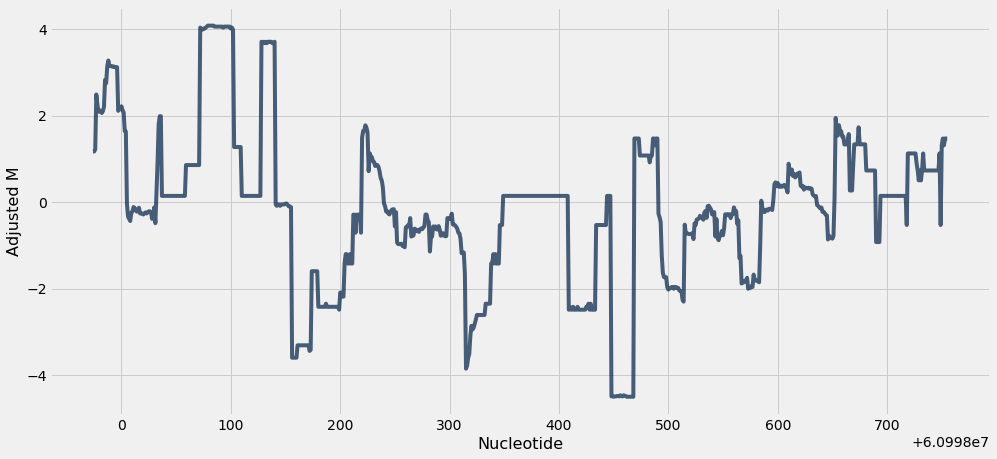

In [563]:
MA_normalization(read_data).with_column("Nucleotide", range_clear).where("Nucleotide",are.between(limit.item(0), limit.item(1))).plot(2, 0,width=15, height=7)#.column("Adjusted M")

In [564]:
#!/usr/bin/env python
# Implementation of algorithm from https://stackoverflow.com/a/22640362/6029703
import numpy as np
import pylab

def thresholding_algo_reversed(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[-lag] = np.mean(y[-lag:])
    stdFilter[-lag] = np.std(y[-lag:])
    for i in reversed(range(0, len(y)-lag)):
        if abs(y[i] - avgFilter[i+1]) > threshold * stdFilter [i+1]:
            if y[i] > avgFilter[i+1]:
                signals[i] = 1
            else:
                signals[i] = 0
            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i+1]
            avgFilter[i] = np.mean(filteredY[i:(i+lag)])
            stdFilter[i] = np.std(filteredY[i:(i+lag)])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[i:(i+lag)])
            stdFilter[i] = np.std(filteredY[i:(i+lag)])
    return dict(signals = np.asarray(signals),
        avgFilter = np.asarray(avgFilter),
        stdFilter = np.asarray(stdFilter))

#!/usr/bin/env python
# Implementation of algorithm from https://stackoverflow.com/a/22640362/6029703
from numba.decorators import jit
import numpy as np

#The original version is here: https://gist.github.com/ximeg/587011a65d05f067a29ce9c22894d1d2
#I made small changes and used numba to do it faster.
  
@jit
def thresholding_algo2(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = np.zeros(len(y))
    stdFilter = np.zeros(len(y))
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def peak_detection_smoothed_zscore_v2(x, lag, threshold, influence):
    '''
    iterative smoothed z-score algorithm
    Implementation of algorithm from https://stackoverflow.com/a/22640362/6029703
    '''
    import numpy as np
    labels = np.zeros(len(x))
    filtered_y = np.array(x)
    avg_filter = np.zeros(len(x))
    std_filter = np.zeros(len(x))
    var_filter = np.zeros(len(x))

    avg_filter[lag - 1] = np.mean(x[0:lag])
    std_filter[lag - 1] = np.std(x[0:lag])
    var_filter[lag - 1] = np.var(x[0:lag])
    for i in range(lag, len(x)):
        if abs(x[i] - avg_filter[i - 1]) > threshold * std_filter[i - 1]:
            if x[i] > avg_filter[i - 1]:
                labels[i] = 1
            else:
                labels[i] = -1
            filtered_y[i] = influence * x[i] + (1 - influence) * filtered_y[i - 1]
        else:
            labels[i] = 0
            filtered_y[i] = x[i]
        # update avg, var, std
        avg_filter[i] = avg_filter[i - 1] + 1. / lag * (filtered_y[i] - filtered_y[i - lag])
        var_filter[i] = var_filter[i - 1] + 1. / lag * ((filtered_y[i] - avg_filter[i - 1]) ** 2 - (
            filtered_y[i - lag] - avg_filter[i - 1]) ** 2 - (filtered_y[i] - filtered_y[i - lag]) ** 2 / lag)
        std_filter[i] = np.sqrt(var_filter[i])

    return dict(signals=labels,
                avgFilter=avg_filter,
                stdFilter=std_filter)

(-1.5, 1.5)

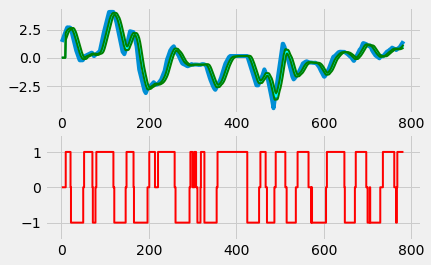

In [565]:
# Data
#data_comp = data_comp.take(np.arange(0,200))
y = data_comp.column(3) 

# Settings: lag = 30, threshold = 5, influence = 0
lag = 10
threshold = 1
influence = 0.2

# Run algo with settings from above
result = peak_detection_smoothed_zscore_v2(y, lag=lag, threshold=threshold, influence=influence)

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)
#data_comp.plot(0,4, width=5.5, height=2)

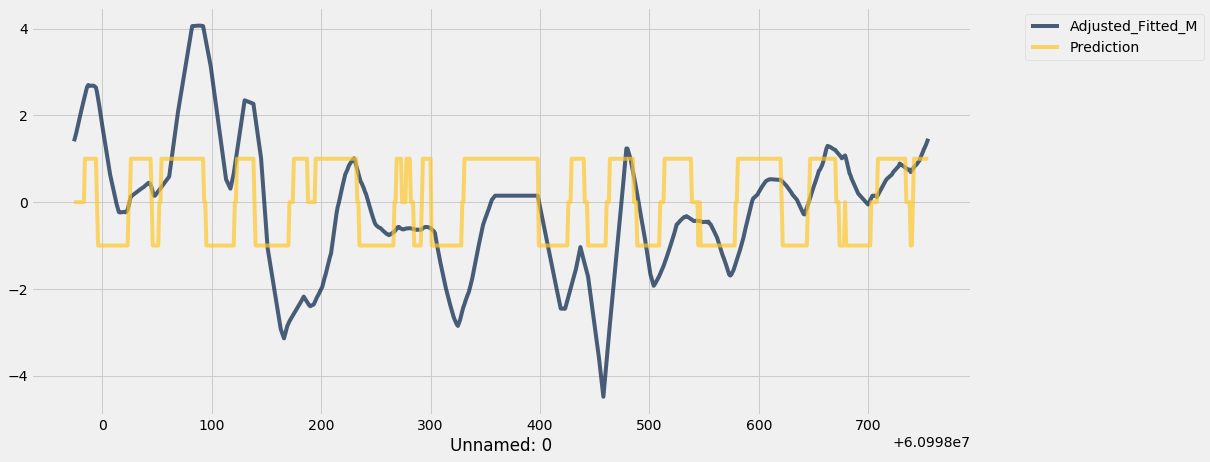

In [566]:
data_comp = data_comp.with_column("Prediction", result['signals'])
data_comp.plot(0,make_array(3,4),width=15, height=7)

summary_tbl = data_comp.with_column("Greater Binding in Condition 1", data_comp.column(4)==1)
summary_tbl = summary_tbl.with_column("Greater Binding in Condition 2", data_comp.column(4)==(-1))

cond_1 = ranges(summary_tbl.where("Greater Binding in Condition 1", are.equal_to(True)).column("Unnamed: 0"))
cond_2 = ranges(summary_tbl.where("Greater Binding in Condition 2", are.equal_to(True)).column("Unnamed: 0"))
cond1 = cond_1.where("range", are.above(3))
cond2 = cond_2.where("range", are.above(3))

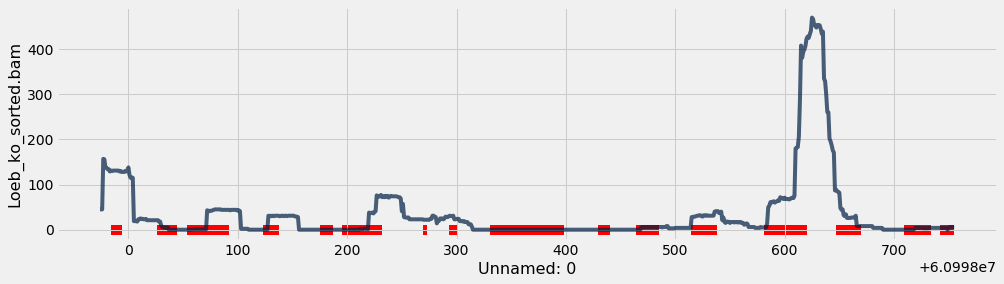

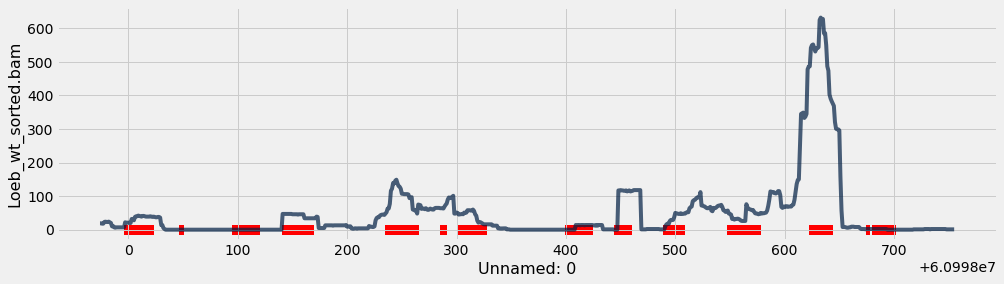

In [567]:
data_comp.plot(0, 1, width=15)
for i in np.arange(len(cond1.column(0))):
    plt.plot(make_array(cond1.column(0).item(i), cond1.column(1).item(i)), make_array(0, 0), color='red', lw=10, zorder=0)
    
data_comp.plot(0, 2, width=15)
for i in np.arange(len(cond2.column(0))):
    plt.plot(make_array(cond2.column(0).item(i), cond2.column(1).item(i)), make_array(0, 0), color='red', lw=10, zorder=0)